In [ ]:
# !pip install koreanize_matplotlib
# !pip install optuna
# !pip install lightgbm

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import koreanize_matplotlib
import seaborn as sns
import pandas as pd
import numpy as np

import optuna
from optuna.samplers import TPESampler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold

In [7]:
pd.options.display.max_columns = 50

data = pd.read_csv('/content/drive/MyDrive/공공데이터_자전거/code/analyze_data.csv')

In [8]:
data['적설(cm)'] = data['적설(cm)'].fillna(0)
data['강수량(mm)'] = data['강수량(mm)'].fillna(0)
data['풍속(m/s)'] = data['풍속(m/s)'].fillna(0)

In [9]:
data.isnull().sum().sum()

32

In [10]:
columns_of_interest = ['남성', '여성', '내국인', '비회원', '1920~1929', '1930~1939', '1940~1949', '1950~1959',
                       '1960~1969', '1970~1979', '1980~1989', '1990~1999', '2000~2009', '2010~2019']

null_data = data[data[columns_of_interest].isna().all(axis=1)]
null_data

,대여일자,남성,여성,내국인,비회원,1920~1929,1930~1939,1940~1949,1950~1959,1960~1969,1970~1979,1980~1989,1990~1999,2000~2009,2010~2019,대여,기타회원,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),전운량(10분위),지면온도(°C),1시간평균 미세먼지농도(㎍/㎥)
876,2022-08-09 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,25.6,6.4,3.8,95,0.0,10,26.0,18
878,2022-08-09 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,25.3,14.1,2.9,96,0.0,10,25.3,5


In [11]:
set1_1 = data[data['대여일자']== '2022-08-07 13:00:00']
set1_2 = data[data['대여일자']== '2022-08-07 13:00:00']
set1_av = (set1_1['지면온도(°C)'] + set1_2['지면온도(°C)']) / 2
data.at[872, '지면온도(°C)'] = set1_av


set2_1 = data[data['대여일자']== '2023-11-09 11:00:00']
set2_2 = data[data['대여일자']== '2023-11-11 11:00:00']
set2_av = ((set2_1['지면온도(°C)'].iloc[0] + set2_2['지면온도(°C)'].iloc[0]) / 2)
data.at[11364, '지면온도(°C)'] = set2_av

<ipython-input-11-759f7eb81c9a>:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data.at[872, '지면온도(°C)'] = set1_av


In [12]:
df = data.drop(null_data.index, axis=0)
df.isnull().sum().sum()

0

In [13]:
# 0: 월요일
# 1: 화요일
# 2: 수요일
# 3: 목요일
# 4: 금요일
# 5: 토요일
# 6: 일요일

In [14]:
def process_total_data(total_data):
    total_data = total_data.fillna(0)
    total_data['대여일자'] = pd.to_datetime(total_data['대여일자'])

    # 년, 월, 일, 시간, 요일 컬럼 생성
    total_data['년'] = total_data['대여일자'].dt.year
    total_data['월'] = total_data['대여일자'].dt.month
    total_data['일'] = total_data['대여일자'].dt.day
    total_data['시간'] = total_data['대여일자'].dt.hour
    total_data["요일"] = total_data["대여일자"].dt.dayofweek

    return total_data

In [15]:
df_1 = process_total_data(df)

In [16]:
def categorize_cloudiness(row):
    if 0 <= row <= 2:
        return 0 # 맑음
    elif 3 <= row <= 5:
        return 1 # 대체로 맑음
    elif 6 <= row <= 8:
        return 2 # 대체로 흐림
    elif 9 <= row <= 10:
        return 3 # 흐림
    else:
        return 4  # 알 수 없음

df_1['구름'] = df_1['전운량(10분위)'].apply(categorize_cloudiness)

In [17]:
def categorize_snowfall(row):
    if row == 0:
        return 0 # 맑음
    elif row < 0.1:
        return 1 # 약한 눈
    elif 0.1 <= row <= 2.9:
        return 2 # 적당한 눈
    elif row >= 3:
        return 3 # 강한 눈
    else:
        return 4 # 알 수 없음

df_1['눈'] = df_1['적설(cm)'].apply(categorize_snowfall)

In [18]:
def categorize_rainfall(row):
    if row == 0:
        return 0 # 맑음
    elif row < 0.2:
        return 1 # 약한 비
    elif 0.1 <= row <= 19.9:
        return 2 # 적당한 비
    elif row >= 20:
        return 3 # 강한 비
    else:
        return 4 # 알 수 없음

df_1['비'] = df_1['강수량(mm)'].apply(categorize_rainfall)

In [19]:
holidays = pd.to_datetime([
    '2023-06-06',  # 현충일
    '2023-08-15',  # 광복절
    '2023-09-28',  # 추석 연휴 시작
    '2023-09-29',  # 추석
    '2023-09-30',  # 추석 연휴 끝
    '2023-10-03',  # 개천절
    '2023-10-09',  # 한글날
    '2024-01-01',  # 신정
    '2024-02-09',  # 설날 연휴 시작
    '2024-02-10',  # 설날
    '2024-02-11',  # 설날 연휴 끝
    '2024-03-01',  # 삼일절
    '2024-05-05',  # 어린이날
    '2024-05-15',  # 석가탄신일
    '2024-06-06'   # 현충일
])

# 대체 공휴일을 고려한 공휴일 계산 함수
def is_holiday_or_substitute(date):
    # 날짜만 추출
    date_only = date.date()

    # 공휴일인지 확인
    if pd.Timestamp(date_only) in holidays:
        return 1

    # 월요일일 때, 그 전날이 공휴일인지 확인 (대체 공휴일)
    if date.weekday() == 0:  # 월요일
        prev_day = date - pd.Timedelta(days=1)  # 일요일
        prev_prev_day = date - pd.Timedelta(days=2)  # 토요일
        if prev_day.date() in holidays.date or prev_prev_day.date() in holidays.date:
            return 1

    return 0

# '대여일자' 컬럼을 datetime 형식으로 변환
df_1['대여일자'] = pd.to_datetime(df_1['대여일자'])

# 공휴일 컬럼 생성 (날짜만 기준으로 공휴일 판단)
df_1['공휴일'] = df_1['대여일자'].apply(is_holiday_or_substitute)

In [20]:
# 주중 컬럼 생성 (주말과 공휴일을 제외한 주중 = 1, 그 외는 0)
def categorize_weekday(row):
    if row['대여일자'].weekday() >= 5:  # 토요일(5) 또는 일요일(6)
        return 0
    elif row['공휴일'] == 1:  # 공휴일인 경우
        return 0
    else:
        return 1

df_1['주중'] = df_1.apply(categorize_weekday, axis=1)

In [21]:
def categorize_wind_speed(wind_speed):
    if wind_speed < 3:
        return 0 # 약한 바람
    elif 4 <= wind_speed < 9:
        return 1 # 약간 강한 바람
    elif 9 <= wind_speed < 14:
        return 2 # 강한 바람
    else:
        return 3 # 매우 강한 바람

df_1['바람'] = df_1['풍속(m/s)'].apply(categorize_wind_speed)

In [22]:
def categorize_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    elif month in [12, 1, 2]:
        return 3  # 겨울

df_1['계절'] = df_1['월'].apply(categorize_season)

In [23]:
df_1.rename(columns={'1시간평균 미세먼지농도(㎍/㎥)': '미세먼지'}, inplace=True)

def categorize_dust(pm_value):
    if pm_value <= 30:
        return 0  # 맑음
    elif pm_value <= 80:
        return 1  # 보통
    elif pm_value <= 150:
        return 2  # 나쁨
    else:
        return 3  # 매우 나쁨

df_1['미세먼지'] = df_1['미세먼지'].apply(categorize_dust)

In [24]:
def time_sep(hour):
    if 6 <= hour < 10:
        return 0       # 아침 시간대
    elif 10 <= hour < 18:
        return 1     # 오후 시간대
    elif 18 <= hour < 22:
        return 2       # 저녁 시간대
    else:
        return 3        # 밤 시간대

# df_1['시간대'] = df_1['시간'].apply(time_sep)

In [25]:
def calculate_feels(temp, humidity, wind_speed):
    return round(temp - ((0.55 - 0.0055 * humidity) * (temp - 14.5)) + 0.33 * wind_speed, 1)

# df_1['체감온도'] = df_1.apply(lambda row: calculate_feels(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)

In [26]:
# analyze data
df_1.to_csv('/content/drive/MyDrive/공공데이터_자전거/code/no_drop_analyze_data.csv', index=False)
df_1.head(2)

,대여일자,남성,여성,내국인,비회원,1920~1929,1930~1939,1940~1949,1950~1959,1960~1969,1970~1979,1980~1989,1990~1999,2000~2009,2010~2019,대여,기타회원,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),전운량(10분위),지면온도(°C),미세먼지,년,월,일,시간,요일,구름,눈,비,공휴일,주중,바람,계절
0,2022-07-01 00:00:00,957.0,278.0,1235.0,0.0,0.0,2.0,1.0,20.0,101.0,153.0,195.0,519.0,244.0,0.0,1235.0,787,21.9,0.0,1.1,99,0.0,10,21.9,0,2022,7,1,0,4,3,0,0,0,1,0,1
1,2022-07-01 01:00:00,868.0,203.0,1071.0,0.0,0.0,2.0,2.0,31.0,122.0,148.0,180.0,434.0,152.0,0.0,1071.0,723,22.3,0.0,1.1,99,0.0,6,21.9,0,2022,7,1,1,4,2,0,0,0,1,0,1


In [27]:
def categorize_year(year):
    # if year == 2021:
        # return 0
    if year == 2022:
        return 0
    elif year == 2023:
        return 1
    elif year == 2024:
        return 2
    else:
        return 3

df_1['년'] = df_1['년'].apply(categorize_year)

In [28]:
df_total = df_1.copy()
df_total = df_total.drop(['강수량(mm)', '풍속(m/s)', '적설(cm)', '전운량(10분위)', '내국인'], axis=1)

df1 = df_1.drop(['대여일자', '강수량(mm)', '풍속(m/s)', '적설(cm)', '전운량(10분위)', '내국인'], axis=1)

# 시각화

In [29]:
# correlation_matrix = df1.corr()

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlations')
# plt.show()

In [30]:
# fig, axs = plt.subplots(figsize=(20, 20), ncols=3, nrows=5)
# features = ['남성', '여성', '미세먼지', '년', '월', '시간', '요일', '공휴일', '주중', '바람', '계절', '구름', '눈', '비']

# for i, feature in enumerate(features):
#     row = int(i/3)
#     col = i%3
#     sns.barplot(x=feature, y='대여', data=df1, ax=axs[row][col])

<Axes: xlabel='시간', ylabel='대여'>

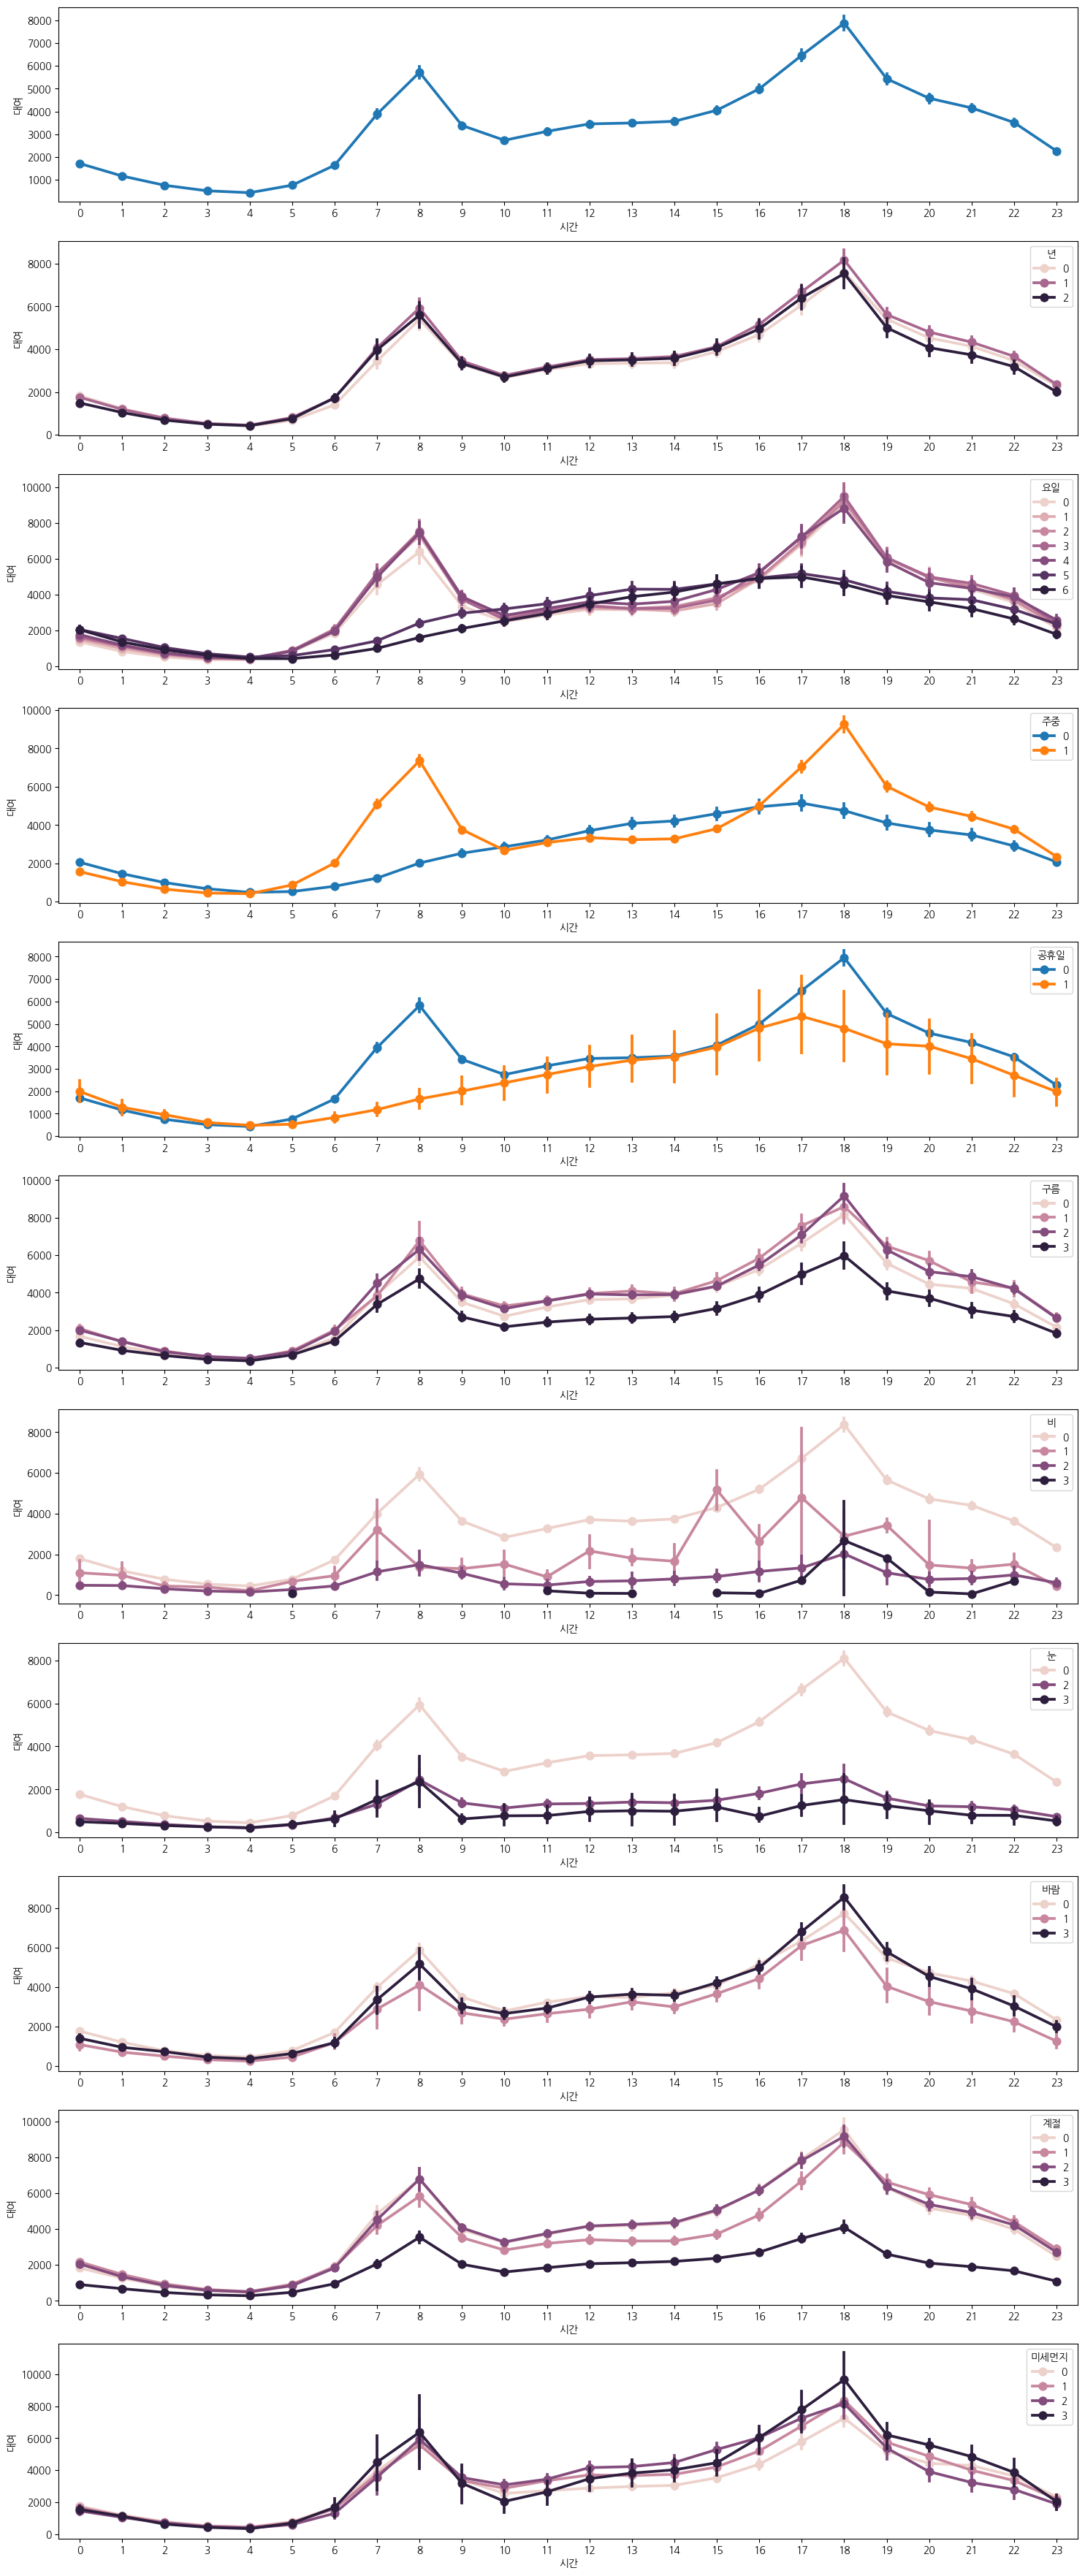

In [31]:
fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7, ax8, ax9, ax10, ax11)= plt.subplots(nrows=11)
fig.set_size_inches(18,45)

sns.pointplot(data=df1, x="시간", y="대여", ax=ax1)

sns.pointplot(data=df1, x="시간", y="대여", hue="년", ax=ax2)

sns.pointplot(data=df1, x="시간", y="대여", hue="요일", ax=ax3)

sns.pointplot(data=df1, x="시간", y="대여", hue="주중", ax=ax4)

sns.pointplot(data=df1, x="시간", y="대여", hue="공휴일", ax=ax5)

sns.pointplot(data=df1, x="시간", y="대여", hue="구름", ax=ax6)

sns.pointplot(data=df1, x="시간", y="대여", hue="비", ax=ax7)

sns.pointplot(data=df1, x="시간", y="대여", hue="눈", ax=ax8)

sns.pointplot(data=df1, x="시간", y="대여", hue="바람", ax=ax9)

sns.pointplot(data=df1, x="시간", y="대여", hue="계절", ax=ax10)

sns.pointplot(data=df1, x="시간", y="대여", hue="미세먼지", ax=ax11)


In [32]:
# sns.catplot(data=df1, x='시간', y='대여', hue='1980~1989')
# plt.title('1980~1989')
# plt.xlabel('시간')
# plt.ylabel('대여')

In [33]:
# sns.catplot(data=df1, x='시간', y='대여', hue='1990~1999')
# plt.title('1980~1989')
# plt.xlabel('시간')
# plt.ylabel('대여')

In [34]:
# sns.catplot(data=df1, x='시간', y='대여', hue='2000~2009')
# plt.title('1980~1989')
# plt.xlabel('시간')
# plt.ylabel('대여')

In [35]:
# sns.catplot(data=df1, x='시간', y='대여', hue='2010~2019')
# plt.title('1980~1989')
# plt.xlabel('시간')
# plt.ylabel('대여')

In [36]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(data=df1, x='시간', y='1980~1989')
# plt.title('1980~1989')
# plt.xlabel('시간')
# plt.ylabel('대여')
# plt.xticks(ticks=range(0, 24), labels=range(0, 24))
# plt.show()

# plt.figure(figsize=(18, 4))
# sns.lineplot(data=df1, x='시간', y='1990~1999')
# plt.title('1990~1999')
# plt.xlabel('시간')
# plt.ylabel('대여')
# plt.xticks(ticks=range(0, 24), labels=range(0, 24))
# plt.show()

# plt.figure(figsize=(18, 4))
# sns.lineplot(data=df1, x='시간', y='2000~2009')
# plt.title('2000~2009')
# plt.xlabel('시간')
# plt.ylabel('대여')
# plt.xticks(ticks=range(0, 24), labels=range(0, 24))
# plt.show()

# plt.figure(figsize=(18, 4))
# sns.lineplot(data=df1, x='시간', y='2010~2019')
# plt.title('2010~2019')
# plt.xlabel('시간')
# plt.ylabel('대여')
# plt.xticks(ticks=range(0, 24), labels=range(0, 24))
# plt.show()

In [37]:
# fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7, ax8, ax9, ax10, ax11)= plt.subplots(nrows=11)
# fig.set_size_inches(18,45)

# sns.pointplot(data=df1, x="시간", y="기타회원", ax=ax1)

# sns.pointplot(data=df1, x="시간", y="기타회원", hue="년", ax=ax2)

# sns.pointplot(data=df1, x="시간", y="기타회원", hue="요일", ax=ax3)

# sns.pointplot(data=df1, x="시간", y="기타회원", hue="주중", ax=ax4)

# sns.pointplot(data=df1, x="시간", y="기타회원", hue="공휴일", ax=ax5)

# sns.pointplot(data=df1, x="시간", y="기타회원", hue="구름", ax=ax6)

# sns.pointplot(data=df1, x="시간", y="기타회원", hue="비", ax=ax7)

# sns.pointplot(data=df1, x="시간", y="기타회원", hue="눈", ax=ax8)

# sns.pointplot(data=df1, x="시간", y="기타회원", hue="바람", ax=ax9)

# sns.pointplot(data=df1, x="시간", y="기타회원", hue="계절", ax=ax10)

# sns.pointplot(data=df1, x="시간", y="기타회원", hue="미세먼지", ax=ax11)


In [38]:
age_columns = ['1920~1929', '1930~1939', '1940~1949', '1950~1959', '1960~1969',
               '1970~1979', '1980~1989', '1990~1999', '2000~2009', '2010~2019']

df2 = df1[age_columns]
df2.nunique()

,0
1920~1929,5
1930~1939,14
1940~1949,36
1950~1959,196
1960~1969,914
1970~1979,1820
1980~1989,2416
1990~1999,3771
2000~2009,2033
2010~2019,67


In [39]:
# hour_12_data = df1[df1['시간'] == 12]

# age_columns = ['1920~1929', '1930~1939', '1940~1949', '1950~1959', '1960~1969',
#                '1970~1979', '1980~1989', '1990~1999', '2000~2009', '2010~2019']

# age_sums = hour_12_data[age_columns].sum()

# age_sums_df = age_sums.reset_index()
# age_sums_df.columns = ['연령대', '대여 건수']

# plt.figure(figsize=(10, 6))
# sns.barplot(x='연령대', y='대여 건수', data=age_sums_df, palette='Blues_d')
# plt.title('12시')
# plt.xlabel('연령대')
# plt.ylabel('대여 건수')
# plt.xticks(rotation=45)
# plt.show()

In [40]:
# hour_12_data = df1[df1['시간'] == 15]

# age_columns = ['1920~1929', '1930~1939', '1940~1949', '1950~1959', '1960~1969',
#                '1970~1979', '1980~1989', '1990~1999', '2000~2009', '2010~2019']

# age_sums = hour_12_data[age_columns].sum()

# age_sums_df = age_sums.reset_index()
# age_sums_df.columns = ['연령대', '대여 건수']

# plt.figure(figsize=(10, 6))
# sns.barplot(x='연령대', y='대여 건수', data=age_sums_df, palette='Blues_d')
# plt.title('15시')
# plt.xlabel('연령대')
# plt.ylabel('대여 건수')
# plt.xticks(rotation=45)
# plt.show()

In [41]:
# hour_12_data = df1[df1['시간'] == 17]

# age_columns = ['1920~1929', '1930~1939', '1940~1949', '1950~1959', '1960~1969',
#                '1970~1979', '1980~1989', '1990~1999', '2000~2009', '2010~2019']

# age_sums = hour_12_data[age_columns].sum()

# age_sums_df = age_sums.reset_index()
# age_sums_df.columns = ['연령대', '대여 건수']

# plt.figure(figsize=(10, 6))
# sns.barplot(x='연령대', y='대여 건수', data=age_sums_df, palette='Blues_d')
# plt.title('17시')
# plt.xlabel('연령대')
# plt.ylabel('대여 건수')
# plt.xticks(rotation=45)
# plt.show()

In [42]:
# hour_12_data = df1[df1['시간'] == 18]

# age_columns = ['1920~1929', '1930~1939', '1940~1949', '1950~1959', '1960~1969',
#                '1970~1979', '1980~1989', '1990~1999', '2000~2009', '2010~2019']

# age_sums = hour_12_data[age_columns].sum()

# age_sums_df = age_sums.reset_index()
# age_sums_df.columns = ['연령대', '대여 건수']

# plt.figure(figsize=(10, 6))
# sns.barplot(x='연령대', y='대여 건수', data=age_sums_df, palette='Blues_d')
# plt.title('18')
# plt.xlabel('연령대')
# plt.ylabel('대여 건수')
# plt.xticks(rotation=45)
# plt.show()

In [43]:
# hour_12_data = df1[df1['시간'] == 8]

# age_columns = ['1920~1929', '1930~1939', '1940~1949', '1950~1959', '1960~1969',
#                '1970~1979', '1980~1989', '1990~1999', '2000~2009', '2010~2019']

# age_sums = hour_12_data[age_columns].sum()

# age_sums_df = age_sums.reset_index()
# age_sums_df.columns = ['연령대', '대여 건수']

# plt.figure(figsize=(10, 6))
# sns.barplot(x='연령대', y='대여 건수', data=age_sums_df, palette='Blues_d')
# plt.title('8시')
# plt.xlabel('연령대')
# plt.ylabel('대여 건수')
# plt.xticks(rotation=45)
# plt.show()

In [44]:
# fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
# fig.set_size_inches(12,5)
# sns.pointplot(data=df1, x="시간", y="대여", hue="기온(°C)", ax=ax1)
# sns.pointplot(data=df1, x="시간", y="대여", hue="습도(%)", ax=ax2)
# sns.pointplot(data=df1, x="시간", y="대여", hue="요일", ax=ax3)


In [45]:
# df1['기온(°C)'].plot(kind='hist', bins=20, alpha=0.7, figsize=(10, 5))
# plt.title('기온 분포에 따른 대여 건수')
# plt.xlabel('기온(°C)')
# plt.ylabel('대여 건수')
# plt.show()

In [46]:
# df1['습도(%)'].plot(kind='hist', bins=20, alpha=0.7, figsize=(10, 5))
# plt.title('습도 분포에 따른 대여 건수')
# plt.xlabel('습도(%)')
# plt.ylabel('대여 건수')
# plt.show()

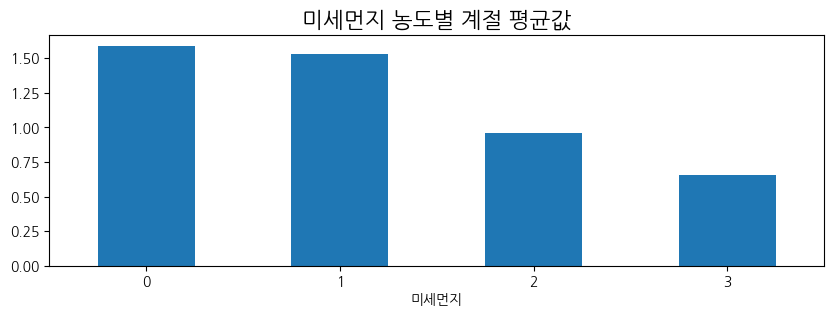

In [47]:
df1.groupby(['미세먼지'])['계절'].mean().plot.bar(rot=0, figsize=(10, 3))
plt.title('미세먼지 농도별 계절 평균값', fontsize=16)
plt.show()

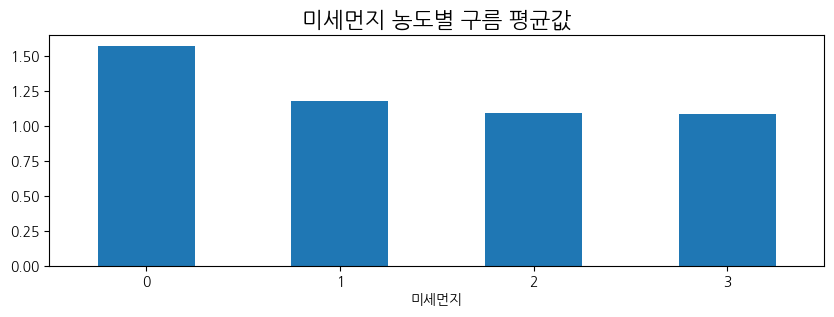

In [48]:
df1.groupby(['미세먼지'])['구름'].mean().plot.bar(rot=0, figsize=(10, 3))
plt.title('미세먼지 농도별 구름 평균값', fontsize=16)
plt.show()

In [49]:
# df1.groupby(['구름'])['대여'].mean().plot.bar(rot=0, figsize=(10, 3))
# plt.title('구름별 대여 평균값', fontsize=16)
# plt.show()

In [50]:
# corr_matrix = df1[['대여', '기온(°C)', '습도(%)', '지면온도(°C)', '미세먼지', '월', '요일', '구름', '눈', '비', '공휴일', '주중', '바람', '계절']].corr()

# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
# plt.show()

In [51]:
cluster_X = df1.copy()

df1.drop(['비회원', '남성', '여성', '1920~1929','1930~1939','1940~1949','1950~1959','1960~1969','1970~1979','1980~1989','1990~1999','2000~2009','2010~2019'], axis=1, inplace=True)
df1['대여'] = df1['대여'] + df1['기타회원']
df1.drop(['기타회원'], axis=1, inplace=True)

df_total.drop(['비회원', '남성', '여성', '1920~1929','1930~1939','1940~1949','1950~1959','1960~1969','1970~1979','1980~1989','1990~1999','2000~2009','2010~2019'], axis=1, inplace=True)
df_total['대여'] = df_total['대여'] + df_total['기타회원']
df_total.drop(['기타회원'], axis=1, inplace=True)


In [52]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))
    return rmsle(y, pred)

scores_1 = make_scorer(evaluate_regr)

# test data

In [53]:
test_bike = pd.read_csv('/content/drive/MyDrive/공공데이터_자전거/code/test_data.csv')

test_bike['적설(cm)'] = test_bike['적설(cm)'].fillna(0)
test_bike['강수량(mm)'] = test_bike['강수량(mm)'].fillna(0)
test_bike['풍속(m/s)'] = test_bike['풍속(m/s)'].fillna(0)

test_bike.isnull().sum().sum()

0

In [54]:
test_bike = process_total_data(test_bike)
test_bike['계절'] = test_bike['월'].apply(categorize_season)
test_bike['바람'] = test_bike['풍속(m/s)'].apply(categorize_wind_speed)

test_bike['대여일자'] = pd.to_datetime(test_bike['대여일자'])
test_bike['공휴일'] = test_bike['대여일자'].apply(is_holiday_or_substitute)
test_bike['주중'] = test_bike.apply(categorize_weekday, axis=1)

test_bike['비'] = test_bike['강수량(mm)'].apply(categorize_rainfall)
test_bike['눈'] = test_bike['적설(cm)'].apply(categorize_snowfall)
test_bike['구름'] = test_bike['전운량(10분위)'].apply(categorize_cloudiness)

test_bike.rename(columns={'1시간평균 미세먼지농도(㎍/㎥)': '미세먼지'}, inplace=True)
test_bike['미세먼지'] = test_bike['미세먼지'].apply(categorize_dust)
test_bike['년'] = test_bike['년'].apply(categorize_year)

# test_bike['시간대'] = test_bike['시간'].apply(time_sep)
# test_bike['체감온도'] = test_bike.apply(lambda row: calculate_feels(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)

test_bike = test_bike.drop(['대여일자', '강수량(mm)', '풍속(m/s)', '적설(cm)', '전운량(10분위)', '내국인'], axis=1)
test_bike.drop(['남성', '여성', '1920~1929','1930~1939','1940~1949','1950~1959','1960~1969','1970~1979','1980~1989','1990~1999','2000~2009','2010~2019'], axis=1, inplace=True)


In [55]:
test_bike = test_bike.drop(['비회원'], axis=1)
test_bike.head(2)

,대여,기타회원,기온(°C),습도(%),지면온도(°C),미세먼지,년,월,일,시간,요일,계절,바람,공휴일,주중,비,눈,구름
0,2812,1216,18.3,82,18.8,0,2,6,1,0,5,1,0,0,0,0,0,3
1,2036,890,18.3,82,18.6,0,2,6,1,1,5,1,0,0,0,0,0,3


In [56]:
test_bike['대여'] = test_bike['대여'] + test_bike['기타회원']

test_bike.drop(['기타회원'], axis=1, inplace=True)
test_bike.head(2)

,대여,기온(°C),습도(%),지면온도(°C),미세먼지,년,월,일,시간,요일,계절,바람,공휴일,주중,비,눈,구름
0,4028,18.3,82,18.8,0,2,6,1,0,5,1,0,0,0,0,0,3
1,2926,18.3,82,18.6,0,2,6,1,1,5,1,0,0,0,0,0,3


In [57]:
pred_X = test_bike.drop(['대여'], axis=1)
pred_y = test_bike['대여']
# pred_y_log = np.log1p(pred_y)

In [58]:
# ca_col = ['미세먼지', '년', '월', '일', '시간', '요일', '구름', '눈', '비', '공휴일', '주중', '바람', '계절']

# for col in ca_col:
#     pred_X[col] = pred_X[col].astype('category')

# pred_X = pred_X[df1.columns]

# model data

In [59]:
model_bike = pd.read_csv('/content/drive/MyDrive/공공데이터_자전거/data/weather/total_data.csv')

model_bike['적설(cm)'] = model_bike['적설(cm)'].fillna(0)
model_bike['강수량(mm)'] = model_bike['강수량(mm)'].fillna(0)
model_bike['풍속(m/s)'] = model_bike['풍속(m/s)'].fillna(0)
model_bike.drop(['풍향(16방위)'], axis=1, inplace=True)

model_bike.isnull().sum().sum()

7

In [60]:
set1_1 = model_bike[model_bike['대여일자']== '2021-06-10-21']
set1_2 = model_bike[model_bike['대여일자']== '2021-06-12-21']

set2_1 = model_bike[model_bike['대여일자']== '2021-06-10-22']
set2_2 = model_bike[model_bike['대여일자']== '2021-06-12-22']

set3_1 = model_bike[model_bike['대여일자']== '2021-06-10-23']
set3_2 = model_bike[model_bike['대여일자']== '2021-06-12-23']

set4_1 = model_bike[model_bike['대여일자']== '2021-08-11-00']
set4_2 = model_bike[model_bike['대여일자']== '2021-08-13-00']

set5_1 = model_bike[model_bike['대여일자']== '2021-08-11-01']
set5_2 = model_bike[model_bike['대여일자']== '2021-08-13-01']

set1_av = (set1_1['지면온도(°C)'].iloc[0] + set1_2['지면온도(°C)'].iloc[0]) / 2
set2_av = (set2_1['지면온도(°C)'].iloc[0] + set2_2['지면온도(°C)'].iloc[0]) / 2
set3_av = (set3_1['지면온도(°C)'].iloc[0] + set3_2['지면온도(°C)'].iloc[0]) / 2
set4_av = (set4_1['지면온도(°C)'].iloc[0] + set4_2['지면온도(°C)'].iloc[0]) / 2
set5_av = (set5_1['지면온도(°C)'].iloc[0] + set5_2['지면온도(°C)'].iloc[0]) / 2
model_bike.at[3729, '지면온도(°C)'] = set1_av
model_bike.at[3730, '지면온도(°C)'] = set2_av
model_bike.at[3731, '지면온도(°C)'] = set3_av
model_bike.at[3732, '지면온도(°C)'] = set4_av
model_bike.at[3733, '지면온도(°C)'] = set5_av


set6_1 = model_bike[model_bike['대여일자']== '2021-08-13-19']
set6_2 = model_bike[model_bike['대여일자']== '2021-08-15-19']

set7_1 = model_bike[model_bike['대여일자']== '2021-08-15-19']
set7_2 = model_bike[model_bike['대여일자']== '2021-08-17-19']

set6_av = (set6_1['전운량(10분위)'].iloc[0] + set6_2['전운량(10분위)'].iloc[0]) / 2
set7_av = (set7_1['전운량(10분위)'].iloc[0] + set7_2['전운량(10분위)'].iloc[0]) / 2
model_bike.at[5191, '전운량(10분위)'] = set6_av
model_bike.at[5236, '전운량(10분위)'] = set7_av


columns_of_interest = ['지면온도(°C)']
null_model_bike2 = model_bike[model_bike[columns_of_interest].isna().all(axis=1)]
null_model_bike2

,대여일자,대여,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),전운량(10분위),지면온도(°C),1시간평균 미세먼지농도(㎍/㎥)


In [61]:
columns_of_interest = ['전운량(10분위)']
null_data2 = model_bike[model_bike[columns_of_interest].isna().all(axis=1)]
null_data2

,대여일자,대여,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),전운량(10분위),지면온도(°C),1시간평균 미세먼지농도(㎍/㎥)


In [62]:
print(model_bike.isnull().sum().sum())

0


In [63]:
model_bike = process_total_data(model_bike)
model_bike['계절'] = model_bike['월'].apply(categorize_season)
model_bike['바람'] = model_bike['풍속(m/s)'].apply(categorize_wind_speed)

model_bike['대여일자'] = pd.to_datetime(model_bike['대여일자'])
model_bike['공휴일'] = model_bike['대여일자'].apply(is_holiday_or_substitute)
model_bike['주중'] = model_bike.apply(categorize_weekday, axis=1)

model_bike['비'] = model_bike['강수량(mm)'].apply(categorize_rainfall)
model_bike['눈'] = model_bike['적설(cm)'].apply(categorize_snowfall)
model_bike['구름'] = model_bike['전운량(10분위)'].apply(categorize_cloudiness)

model_bike.rename(columns={'1시간평균 미세먼지농도(㎍/㎥)': '미세먼지'}, inplace=True)
model_bike['미세먼지'] = model_bike['미세먼지'].apply(categorize_dust)
model_bike['년'] = model_bike['년'].apply(categorize_year)

# model_bike['시간대'] = model_bike['시간'].apply(time_sep)
# model_bike['체감온도'] = model_bike.apply(lambda row: calculate_feels(row['기온(°C)'], row['습도(%)'], row['풍속(m/s)']), axis=1)

In [64]:
model_df = model_bike.sort_values(by='대여일자', ascending=True)
model_df = model_df.reset_index(drop=True)

model_df = model_df.drop(['강수량(mm)', '풍속(m/s)', '적설(cm)', '전운량(10분위)'], axis=1)

total_data = pd.concat([model_df, df_total], axis=0)

total_raw = total_data.copy()

def categorize_year_restore(year):
    if year == 0:
        return 2021
    elif year == 1:
        return 2022
    elif year == 2:
        return 2023
    elif year == 3:
        return 2024
    else:
        return 4

total_raw['년'] = total_raw['년'].apply(categorize_year_restore)

total_raw.to_csv('/content/drive/MyDrive/공공데이터_자전거/code/total_raw.csv', index=False)
total_raw

# print(total_data.isnull().sum().sum())
# total_data = total_data[df1.columns]

,대여일자,대여,기온(°C),습도(%),지면온도(°C),미세먼지,년,월,일,시간,요일,계절,바람,공휴일,주중,비,눈,구름
0,2021-01-01 00:00:00,388.0,-8.3,66,-6.8,1,2024,1,1,0,4,3,0,0,1,0,0,0
1,2021-01-01 01:00:00,339.0,-8.7,68,-6.9,0,2024,1,1,1,4,3,0,0,1,0,0,0
2,2021-01-01 02:00:00,258.0,-9.1,69,-7.1,1,2024,1,1,2,4,3,0,0,1,0,0,0
3,2021-01-01 03:00:00,204.0,-9.3,70,-7.3,1,2024,1,1,3,4,3,0,0,1,0,0,0
4,2021-01-01 04:00:00,145.0,-9.3,71,-7.5,0,2024,1,1,4,4,3,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15977,2024-05-31 18:00:00,18254.0,21.4,45,27.0,0,2023,5,31,18,4,0,1,0,1,0,0,1
15978,2024-05-31 19:00:00,12292.0,18.7,65,20.9,0,2023,5,31,19,4,0,0,0,1,2,0,2
15979,2024-05-31 21:00:00,9320.0,18.7,67,19.0,0,2023,5,31,21,4,0,0,0,1,0,0,3
15980,2024-05-31 22:00:00,8053.0,18.8,73,19.0,0,2023,5,31,22,4,0,0,0,1,0,0,3


((array([-3.92494389, -3.70598482, -3.58605009, ...,  3.58605009,
          3.70598482,  3.92494389]),
  array([ 1.38629436,  1.60943791,  1.79175947, ..., 10.05173513,
         10.09843737, 10.10475353])),
 (1.043359414725124, 8.095745879024225, 0.9769327497522136))

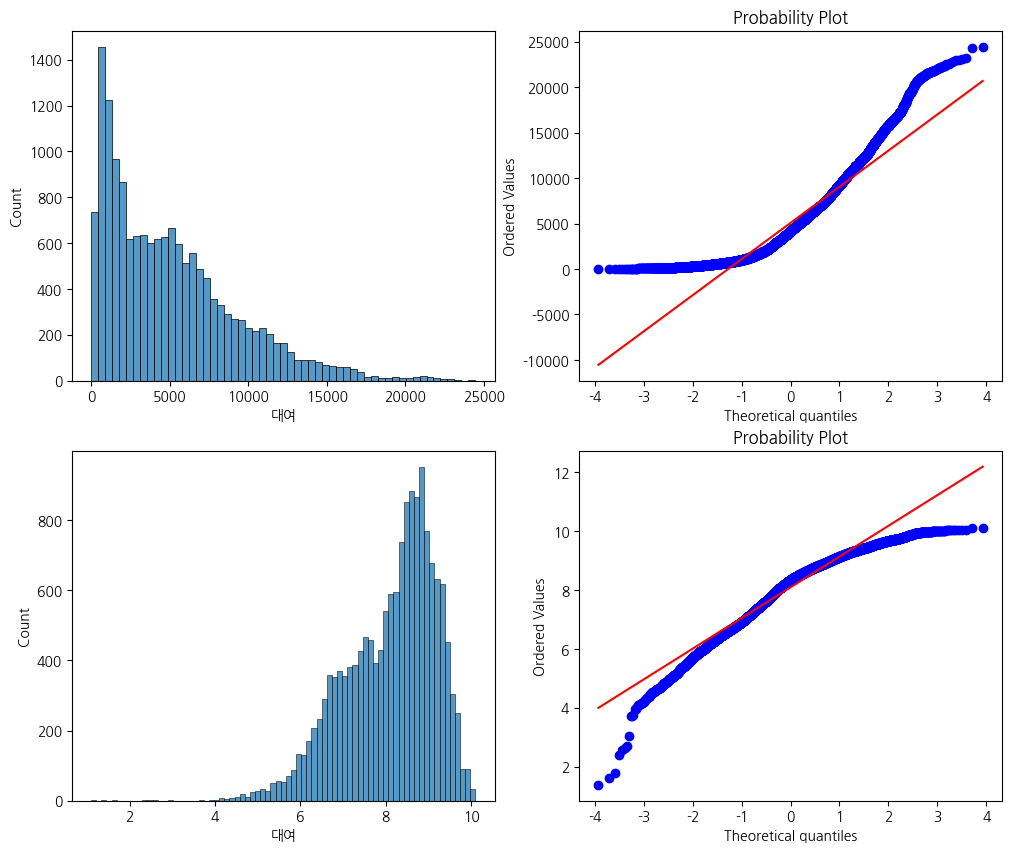

In [65]:
from scipy import stats

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.histplot(df1["대여"], ax=axes[0][0])
stats.probplot(df1["대여"], dist='norm', fit=True, plot=axes[0][1])

sns.histplot(np.log(df1["대여"]), ax=axes[1][0])
stats.probplot(np.log1p(df1["대여"]), dist='norm', fit=True, plot=axes[1][1])

In [66]:
# y = total_data['대여']
# y_log = np.log1p(y)
# X = total_data.drop(['대여'], axis=1)


y = df1['대여']
y_log = np.log1p(y)
X = df1.drop(['대여'], axis=1)

In [67]:
ca_col = ['미세먼지', '년', '월', '일', '시간', '요일', '구름', '눈', '비', '공휴일', '주중', '바람', '계절'] # '시간대'

for col in ca_col:
    X[col] = X[col].astype('category')

# model

In [68]:
# !pip install catboost

In [69]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
import optuna

ModuleNotFoundError: No module named 'catboost'

In [ ]:
# X.drop(['cluster'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = ['미세먼지', '년', '월', '일', '시간', '요일', '구름', '눈', '비', '공휴일', '주중', '바람', '계절'] # '시간대'
continuous_cols = ['기온(°C)', '습도(%)', '지면온도(°C)'] # '체감온도'

X_scale = X.copy()
test_scale = pred_X.copy()

scaler = StandardScaler()
X_scale_1 = scaler.fit_transform(X[continuous_cols])
X_scale[continuous_cols] = pd.DataFrame(X_scale_1, columns=continuous_cols)

test_scale_1 = scaler.transform(pred_X[continuous_cols])
test_scale[continuous_cols] = pd.DataFrame(test_scale_1, columns=continuous_cols)

In [ ]:
X_scale.head(2)

In [ ]:
test_scale = test_scale[X_scale.columns]
ca_col = ['미세먼지', '년', '월', '일', '시간', '요일', '구름', '눈', '비', '공휴일', '주중', '바람', '계절'] # '시간대'

for col in ca_col:
    test_scale[col] = test_scale[col].astype('category')

test_scale.head(2)

In [ ]:
s

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)


rf = RandomForestRegressor(n_estimators=100, max_depth=7)
rf.fit(X_train, y_train)


y_train_pred = rf.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)

y_test_pred = rf.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"훈련 데이터 MSE: {train_mse}")
print(f"테스트 데이터 MSE: {test_mse}")

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=7)
rf.fit(X, y_log)

score = cross_val_score(rf, X, y_log, cv=k_fold, scoring=scores_1)
score = score.mean()

# MSE: 예측과 실제 값 사이의 제곱된 오차의 평균을 계산한 값. 큰 오차에 대해 더 큰 패널티를 부과 -> 의료 데이터나 금융 데이터에서 큰 오차가 발생하면 심각한 영향을 미칠 수 있는 경우
# MAE: 각 오차의 절대값을 계산하여 평균을 내기 때문에 직관적이고 해석이 쉬운 지표 -> 대여 수요나 기온 예측 등에서 큰 오차가 상대적으로 덜 중요한 경우 사용
# RMSE: 절대적인 오차 크기를 나타내기 때문에 직관적인 평가 지표로 자주 사용 -> 집값, 온도, 거리 등의 예측에서 예측 오차를 원래 값의 단위로 보고 싶은 경우
# RMSLE: 값의 상대적인 차이를 평가하며, 큰 값에 대해서는 비교적 완화된 패널티를 부과 -> 판매량 예측, 대여 수요 예측, 인구 수 예측 등에서 작은 값보다 큰 값의 상대적인 오차를 중요시하는 경우

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

In [ ]:
rf.fit(X, y_log)

importances = rf.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_log_error

predictions = np.expm1(rf.predict(pred_X))

rmsle = np.sqrt(mean_squared_log_error(pred_y, predictions))
print("RMSLE: ", rmsle)

# XGBoost

In [ ]:
from xgboost import XGBRegressor, DMatrix

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'tree_method': 'hist',         # Use 'hist' for CPU and 'device' for GPU
        'device': 'cuda',              # Set device to CUDA for GPU
        'max_leaves': trial.suggest_int('max_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'enable_categorical': True, # XGBoost에서 범주형 데이터를 직접 처리
        'random_state': 42,
    }

    # model = XGBRegressor(**param)
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []

    for train_idx, val_idx in cv.split(X_scaled, y_log):
        X_train_fold, X_val_fold = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
        y_train_fold, y_val_fold = y_log.iloc[train_idx], y_log.iloc[val_idx]

        dtrain = DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True)
        dval = DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)

        model = XGBRegressor(**param)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)

        y_val_pred = model.predict(X_val_fold)
        rmsle_score = np.sqrt(mean_squared_log_error(y_val_fold, y_val_pred))
        scores.append(rmsle_score)

    return np.mean(scores)

study_name = "xgboost_regression"
study = optuna.create_study(study_name=study_name,
                            sampler=TPESampler(n_startup_trials=35, multivariate=True, seed=0),
                            direction="minimize")
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(f"Best RMSLE: {study.best_value:.5f}")
print("Best params:", best_params)

best_xgb_model = XGBRegressor(**best_params, random_state=42)


In [ ]:
best = {'max_leaves': 56, 'max_depth': 13, 'min_child_weight': 8.12119905536219, 'subsample': 0.950809957248349, 'colsample_bytree': 0.9232265017852777, 'learning_rate': 0.08398744116169907, 'reg_alpha': 1.6634720120556756, 'reg_lambda': 8.469551560678203, 'n_estimators': 952}
best_1 = {'max_leaves': 56, 'max_depth': 13, 'min_child_weight': 8.12119905536219, 'subsample': 0.950809957248349, 'colsample_bytree': 0.9232265017852777, 'learning_rate': 0.08398744116169907, 'reg_alpha': 1.6634720120556756, 'reg_lambda': 8.469551560678203, 'n_estimators': 952}



In [ ]:
model = XGBRegressor(**best_params, random_state=42, enable_categorical=True)
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

%time
# 교차 검증 실행
score = cross_val_score(model, X_scaled, y_log, cv=k_fold, scoring=scores_1)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

model.fit(X, y_log)

In [ ]:
model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method='hist',   # CPU 사용 시 "hist" 또는 "exact"
    device='cuda',        # GPU 사용 시 'cuda'
    enable_categorical=True,
    random_state=42
)

k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

score = cross_val_score(model, X, y_log, cv=k_fold, scoring=scores_1)
score = score.mean()

print("Score= {0:.5f}".format(score))
model.fit(X, y_log)

In [ ]:
predictions = np.expm1(model.predict(test_scaled))

rmsle = np.sqrt(mean_squared_log_error(pred_y, predictions))
print("RMSLE: ", rmsle)

# LightGBM

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))
    return rmsle(y, pred)

scores_1 = make_scorer(evaluate_regr)

In [ ]:
cat_feature_indices = [X.columns.get_loc(col) for col in ca_col]
cat_feature_indices

In [ ]:
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'random_state': 42,
    }

    model = LGBMRegressor(**param, verbose=-1)
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []

    for train_idx, val_idx in cv.split(X_scale, y_log):
        X_train_fold, X_val_fold = X_scale.iloc[train_idx], X_scale.iloc[val_idx]
        y_train_fold, y_val_fold = y_log.iloc[train_idx], y_log.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], eval_metric='rmse', categorical_feature=cat_feature_indices)

        # Predict and compute RMSLE
        y_val_pred = model.predict(X_val_fold)
        rmsle_score = np.sqrt(mean_squared_log_error(y_val_fold, y_val_pred))
        scores.append(rmsle_score)

    return np.mean(scores)

study_name = "lightgbm_regression"
study = optuna.create_study(study_name=study_name,
                            sampler=TPESampler(n_startup_trials=35, multivariate=True, seed=0),
                            direction="minimize")
study.optimize(objective, n_trials=80)


best_params = study.best_params
print(f"Best RMSLE: {study.best_value:.5f}")
print("Best params:", best_params)


best_lgb_model = LGBMRegressor(**best_params, random_state=42)
best_lgb_model.fit(X_scale, y_log, feature_name=['f' + str(i) for i in range(X_scale.shape[1])], categorical_feature=cat_feature_indices)

In [ ]:
importances = best_lgb_model.feature_importances_
features = X.columns  # 또는 학습에 사용한 feature names

# 피처 중요도를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # 중요도가 높은 것이 위로 오도록 반전
plt.show()

In [ ]:
# Best RMSLE: 0.03656
lgbm_params = {'num_leaves': 34, 'min_child_samples': 8, 'min_child_weight': 5.325316456668544, 'max_depth': 13, 'subsample': 0.7026421158456723, 'colsample_bytree': 0.7246788201985975, 'learning_rate': 0.0776661246807487, 'reg_alpha': 0.8174301503642437, 'reg_lambda': 8.339388751265682, 'n_estimators': 979}
lgbm_params_1 = {'num_leaves': 31, 'min_child_samples': 23, 'min_child_weight': 0.16534122797627349, 'max_depth': 15, 'subsample': 0.7104926862912885, 'colsample_bytree': 0.5774381118735717, 'learning_rate': 0.0999090185273468, 'reg_alpha': 1.36640087620078, 'reg_lambda': 9.908607275777644, 'n_estimators': 863}


best_params = {'n_estimators': 409, 'learning_rate': 0.07059598427094783, 'num_leaves': 174, 'max_depth': 20, 'min_child_samples': 9, 'subsample': 0.6372901222707613, 'colsample_bytree': 0.6526970337764204}


test1 = {'num_leaves': 45, 'min_child_samples': 88, 'min_child_weight': 2.808066144674794, 'max_depth': 13, 'subsample': 0.5113815665835714, 'colsample_bytree': 0.9716749941831667, 'learning_rate': 0.023712456804789152, 'reg_alpha': 2.1550767711355845, 'reg_lambda': 9.473705904889243, 'n_estimators': 758}

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
cv_splits = cv.split(X_scale, y_log)

# 결과를 저장할 리스트
scores = []
test_preds = []

# 교차 검증 루프
for i, (train_idx, val_idx) in enumerate(cv_splits):
    model = LGBMRegressor(**best_params, random_state=0, verbose=-1)  # LGBMRegressor 초기화

    # 각 fold의 train/validation 데이터 설정
    X_train_fold, X_val_fold = X_scale.iloc[train_idx], X_scale.iloc[val_idx]
    y_train_fold, y_val_fold = y_log.iloc[train_idx], y_log.iloc[val_idx]

    # 모델 학습
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)],
              eval_metric='rmse', categorical_feature=list(cat_feature_indices))

    # Validation 데이터 예측 및 RMSLE 평가
    val_pred = model.predict(X_val_fold)
    rmsle_score = np.sqrt(mean_squared_log_error(y_val_fold, val_pred))
    scores.append(rmsle_score)

    # Test 데이터 예측 저장
    test_pred = model.predict(test_scale)
    test_preds.append(test_pred)
    print(f'Fold {i + 1} RMSLE: {rmsle_score:.3f}')

# Cross-validation 결과 출력
print(f'Cross-validated RMSLE: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Max RMSLE: {np.max(scores):.3f}')
print(f'Min RMSLE: {np.min(scores):.3f}')

In [ ]:
test_preds_exp = [np.expm1(pred) for pred in test_preds]
y_pred = np.mean(test_preds_exp, axis=0)

In [ ]:
rmsle = np.sqrt(mean_squared_log_error(pred_y, y_pred))
print("RMSLE: ", rmsle)

# old version

In [ ]:
model = LGBMRegressor(**lgbm_params, random_state=0, verbose=-1)

%time
# 교차 검증 실행
score = cross_val_score(model, X, y_log, cv=k_fold, scoring=scores_1)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

model.fit(X, y_log)

In [ ]:
predictions = np.expm1(model.predict(pred_X))

rmsle = np.sqrt(mean_squared_log_error(pred_y, predictions))
print("RMSLE: ", rmsle)

In [ ]:
best_params = {'n_estimators': 409, 'learning_rate': 0.07059598427094783, 'num_leaves': 174, 'max_depth': 20, 'min_child_samples': 9, 'subsample': 0.6372901222707613, 'colsample_bytree': 0.6526970337764204}

In [ ]:
lgbm = LGBMRegressor(**best_params, random_state=0, verbose=-1)
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

%time
# 교차 검증 실행
score = cross_val_score(lgbm, X, y_log, cv=k_fold, scoring=scores_1)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

lgbm.fit(X, y_log)

In [ ]:
predictions = np.expm1(lgbm.predict(pred_X))

rmsle = np.sqrt(mean_squared_log_error(pred_y, predictions))
print("RMSLE: ", rmsle)

In [ ]:
importances = lgbm.feature_importances_
features = X.columns  # 또는 학습에 사용한 feature names

# 피처 중요도를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # 중요도가 높은 것이 위로 오도록 반전
plt.show()

# CatBoost

In [ ]:
def objective(trial):
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'iterations': 1000,
        'depth': trial.suggest_int('depth', 6, 12),
        'random_strength': 0,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 1.0, log=True),
        'random_seed': 42,
        'task_type': 'GPU'
    }

    model = CatBoostRegressor(**params)
    cv = KFold(5, shuffle=True, random_state=0)
    cv_splits = cv.split(X, y_log)
    scores = []

    for train_idx, val_idx in cv_splits:
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y_log.iloc[train_idx], y_log.iloc[val_idx]

        X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=list(ca_col))
        X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=list(ca_col))

        model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=200)

        # RMSLE 수동 계산
        val_pred = model.predict(X_valid_pool)
        rmsle_score = np.sqrt(mean_squared_log_error(y_val_fold, val_pred))
        scores.append(rmsle_score)

    # RMSLE 평균 반환
    return np.mean(scores)

study_name = "catboost_regression"
optimize = False
if optimize:
    study = optuna.create_study(study_name=study_name,
                                sampler=TPESampler(n_startup_trials=35, multivariate=True, seed=0),
                                direction="minimize", load_if_exists=True)

    study.optimize(objective, n_trials=100)
    print(f"Best optimized RMSLE: {study.best_value:0.5f}")
    print(f"Best hyperparameters: {study.best_params}")
    catboost_params = study.best_params
else:
    catboost_params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'learning_rate': 0.08114394459649094,
        'iterations': 1000,
        'depth': 5,
        'random_strength': 0,
        'l2_leaf_reg': 0.7047064221215757,
        'random_seed': 42,
        # 'task_type': 'GPU',
        'verbose': False
    }

In [ ]:
best_cat = {'learning_rate': 0.06380556092044458, 'depth': 8, 'l2_leaf_reg': 0.4424804764191636}
best_cat_1 = {'learning_rate': 0.06380556092044458, 'depth': 8, 'l2_leaf_reg': 0.4424804764191636}

In [ ]:
cat = CatBoostRegressor(**catboost_params, cat_features=list(ca_col))


In [ ]:
categorical_cols

In [ ]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

cv = KFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X_scale, y_log)
scores = []
test_preds = []
X_test_pool = Pool(test_scale, cat_features=categorical_cols)

for i, (train_idx, val_idx) in enumerate(cv_splits):
    model = CatBoostRegressor(**catboost_params)

    # 훈련 및 검증 세트 설정
    X_train_fold, X_val_fold = X_scale.iloc[train_idx], X_scale.iloc[val_idx]
    y_train_fold, y_val_fold = y_log.iloc[train_idx], y_log.iloc[val_idx]

    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=categorical_cols)
    X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=categorical_cols)

    # 모델 학습
    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=200)

    # RMSLE 계산
    val_pred = model.predict(X_valid_pool)
    score = np.sqrt(mean_squared_log_error(y_val_fold, val_pred))  # RMSLE 계산
    scores.append(score)

    # 테스트 데이터 예측
    test_pred = model.predict(X_test_pool)
    test_preds.append(test_pred)
    print(f'Fold {i + 1} RMSLE: {score:.4f}')

# 최종 RMSLE 출력
print(f'Cross-validated RMSLE: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')
print(f'Max RMSLE score: {np.max(scores):.4f}')
print(f'Min RMSLE score: {np.min(scores):.4f}')


In [ ]:
test_preds_exp = [np.expm1(pred) for pred in test_preds]
y_pred = np.mean(test_preds_exp, axis=0)

rmsle = np.sqrt(mean_squared_log_error(pred_y, y_pred))
print("RMSLE: ", rmsle)

In [ ]:
cluster_X

In [ ]:
cluster_X_1 = cluster_X.drop(['대여'], axis=1)
cluster_X_1.head(2)

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(cluster_X_1)

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA 2D Projection')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA 모델 훈련
pca = PCA()
pca.fit(cluster_X_1)

# 설명 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 설명 분산 비율 출력
print(f"설명 분산 비율: {explained_variance_ratio}")
print(f"누적 설명 분산 비율: {cumulative_variance_ratio}")

# 스크리 플롯 그리기
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot')
plt.axhline(y=0.9, color='r', linestyle='--')  # 예시로 누적 설명 분산 비율 90%를 기준으로 표시
plt.show()


In [ ]:
categorical_cols = ['미세먼지', '년', '월', '일', '시간', '요일', '구름', '눈', '비', '공휴일', '주중', '바람', '계절']
continuous_cols = ['기온(°C)', '습도(%)', '지면온도(°C)']

# 1. One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first'로 첫 번째 값을 제거하여 다중공선성 방지
encoded_categorical = encoder.fit_transform(X[categorical_cols])
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols))

# 2. Scaling Continuous Variables
scaler = StandardScaler()
scaled_continuous = scaler.fit_transform(X[continuous_cols])
scaled_df = pd.DataFrame(scaled_continuous, columns=continuous_cols)

# 3. 원핫 인코딩된 데이터와 스케일링된 데이터를 기존 데이터에 결합
X_transformed = pd.concat([scaled_df, encoded_df], axis=1)

# Kmeans

In [ ]:
from sklearn.cluster import KMeans

ssd = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cluster_X_1)
    ssd.append(kmeans.inertia_)

plt.plot(range(1, 10), ssd, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSD (Inertia)')
plt.show()

In [ ]:
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [ ]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

In [ ]:
visualize_silhouette([2,3,4,5], cluster_X_1)
visualize_kmeans_plot_multi([2,3,4,5], cluster_X_1)

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math

In [ ]:
def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 2, 10)  # 클러스터 개수
    init_method = trial.suggest_categorical('init', ['k-means++', 'random'])  # 초기화 방법
    max_iter = trial.suggest_int('max_iter', 100, 500)  # 최대 반복 횟수
    n_init = trial.suggest_int('n_init', 10, 20)  # 초기화 시도 횟수
    tol = trial.suggest_float('tol', 1e-4, 1e-2, log=True)  # 수렴 허용 오차
    algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan', 'full'])

    # KMeans 모델 생성
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init_method,
        max_iter=max_iter,
        n_init=n_init,
        random_state=42
    )

    # 모델 학습 및 예측
    cluster_labels = kmeans.fit_predict(cluster_X_1)

    # 실루엣 스코어 계산 (실루엣 스코어는 1에 가까울수록 군집화가 잘 된 것으로 평가)
    silhouette_avg = silhouette_score(cluster_X_1, cluster_labels)

    return silhouette_avg

# Optuna Study 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')  # 실루엣 스코어 최대화
study.optimize(objective, n_trials=150)  # n_trials 설정에 따라 탐색 횟수 조정

# 최적 파라미터 출력
print("Best parameters:", study.best_params)
print("Best Silhouette Score:", study.best_value)

# 최적 파라미터로 KMeans 모델 재학습
best_params = study.best_params
kmeans_optimal = KMeans(
    n_clusters=best_params['n_clusters'],
    init=best_params['init'],
    max_iter=best_params['max_iter'],
    n_init=best_params['n_init'],
    random_state=42
)

kmeans_optimal.fit(cluster_X_1)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

def visualize_silhouette_gmm(cluster_lists, X_features):

    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):
        # Gaussian Mixture Model 클러스터링 수행
        gmm = GaussianMixture(n_components=n_cluster, max_iter=500, random_state=0)
        cluster_labels = gmm.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : ' + str(n_cluster) + '\n' +
                           'Silhouette Score :' + str(round(sil_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")


def visualize_gmm_plot_multi(cluster_lists, X_features):

    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1', 'PCA2'])

    for ind, n_cluster in enumerate(cluster_lists):

        # Gaussian Mixture Model 클러스터링으로 클러스터링 결과를 dataframe에 저장
        gmm = GaussianMixture(n_components=n_cluster, max_iter=500, random_state=0)
        cluster_labels = gmm.fit_predict(pca_transformed)
        dataframe['cluster'] = cluster_labels

        unique_labels = np.unique(cluster_labels)
        markers = ['o', 's', '^', 'x', '*']

        for label in unique_labels:
            label_df = dataframe[dataframe['cluster'] == label]
            if label == -1:
                cluster_legend = 'Noise'
            else:
                cluster_legend = 'Cluster ' + str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,
                             edgecolor='k', marker=markers[label % len(markers)], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : ' + str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

In [ ]:
visualize_silhouette_gmm([2,3,4,5], cluster_X_1)
visualize_gmm_plot_multi([2,3,4,5], cluster_X_1)

In [ ]:
from sklearn.mixture import GaussianMixture

def objective(trial):
    # Optuna로 튜닝할 파라미터를 정의합니다.
    n_components = trial.suggest_int('n_components', 2, 10)  # 2~5개의 클러스터 중 최적값
    covariance_type = trial.suggest_categorical('covariance_type', ['full', 'tied', 'diag', 'spherical'])  # 공분산 유형
    tol = trial.suggest_float('tol', 1e-4, 1e-2, log=True)  # 수렴 기준
    reg_covar = trial.suggest_float('reg_covar', 1e-6, 1e-3, log=True)  # 수치 안정성 개선
    max_iter = trial.suggest_int('max_iter', 100, 500)  # 반복 횟수
    n_init = trial.suggest_int('n_init', 1, 10)  # 초기화 반복 횟수
    init_params = trial.suggest_categorical('init_params', ['kmeans', 'random'])  # 초기화 방식 선택
    warm_start = trial.suggest_categorical('warm_start', [True, False])  # 이전 결과 재사용 여부


    # GaussianMixture 모델 생성
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        max_iter=max_iter,
        random_state=42
    )

    # 모델 학습 및 예측
    cluster_labels = gmm.fit_predict(cluster_X_1)

    # 실루엣 스코어 계산 (실루엣 스코어는 1에 가까울수록 군집화가 잘 된 것으로 평가)
    silhouette_avg = silhouette_score(cluster_X_1, cluster_labels)

    return silhouette_avg

# Optuna Study 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')  # 실루엣 스코어 최대화
study.optimize(objective, n_trials=150)  # n_trials 설정에 따라 탐색 횟수 조정

# 최적 파라미터 출력
print("Best parameters:", study.best_params)
print("Best Silhouette Score:", study.best_value)

# 최적 파라미터로 GMM 모델 재학습
best_params = study.best_params
gmm_optimal = GaussianMixture(
    n_components=best_params['n_components'],
    covariance_type=best_params['covariance_type'],
    max_iter=best_params['max_iter'],
    random_state=42
)
gmm_optimal.fit(cluster_X_1)

In [ ]:
GMM_best = {'n_components': 3, 'covariance_type': 'spherical', 'tol': 0.00048774218221173864, 'reg_covar': 1.6113286798050956e-06, 'max_iter': 162, 'n_init': 6, 'init_params': 'random', 'warm_start': True}
GMM_best_1 = {'n_components': 2, 'covariance_type': 'spherical', 'tol': 0.00010033429392216301, 'reg_covar': 0.00019279700384210727, 'max_iter': 211, 'n_init': 8, 'init_params': 'random', 'warm_start': True}


In [ ]:
# GMM 모델 생성 및 학습
gmm = GaussianMixture(**GMM_best_1, random_state=42)
gmm.fit(cluster_X_1)  # X는 원본 데이터

# GMM 클러스터 예측
cluster_labels = gmm.predict(cluster_X_1)

# 실루엣 스코어 계산
silhouette_avg = silhouette_score(cluster_X_1, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

# PCA로 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(cluster_X_1)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=20, alpha=0.7)
plt.title('GMM')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import optuna

def objective(trial):
    # DBSCAN의 주요 하이퍼파라미터를 튜닝합니다.
    eps = trial.suggest_float('eps', 0.1, 5.0, log=True)  # eps 범위를 적절히 설정
    min_samples = trial.suggest_int('min_samples', 5, 1000)  # 최소 샘플 수

    # DBSCAN 모델 생성
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # 모델 학습 및 예측
    cluster_labels = dbscan.fit_predict(cluster_X_1)

    # 클러스터링이 제대로 되지 않을 경우 실루엣 스코어 계산 불가 예외 처리
    if len(set(cluster_labels)) <= 1:
        return -1.0  # 유효하지 않은 결과로 처리

    # 실루엣 스코어 계산 (실루엣 스코어는 1에 가까울수록 군집화가 잘 된 것으로 평가)
    silhouette_avg = silhouette_score(cluster_X_1, cluster_labels)

    return silhouette_avg

# Optuna Study 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')  # 실루엣 스코어 최대화
study.optimize(objective, n_trials=150)  # n_trials 설정에 따라 탐색 횟수 조정

# 최적 파라미터 출력
print("Best parameters:", study.best_params)
print("Best Silhouette Score:", study.best_value)

# 최적 파라미터로 DBSCAN 모델 재학습
best_params = study.best_params
dbscan_optimal = DBSCAN(
    eps=best_params['eps'],
    min_samples=best_params['min_samples']
)
dbscan_optimal.fit(cluster_X_1)


In [ ]:
kmean_params = {'n_clusters': 2, 'init': 'k-means++', 'max_iter': 317, 'n_init': 12, 'tol': 0.0006850592283329993, 'algorithm': 'elkan'}
kmean_params_1 = {'n_clusters': 3, 'init': 'k-means++', 'max_iter': 415, 'n_init': 20, 'tol': 0.000289090266994302, 'algorithm': 'elkan'}

In [ ]:
kmeans = KMeans(**kmean_params_1, random_state=42)
kmeans.fit(cluster_X_1)

# KMeans 클러스터 예측
cluster_labels = kmeans.predict(cluster_X_1)

# 실루엣 스코어 계산
silhouette_avg = silhouette_score(cluster_X_1, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

# PCA로 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(cluster_X_1)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=20, alpha=0.7)
plt.title('KMeans Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [ ]:
kmeans = KMeans(**kmean_params, random_state=42)
X_kmeans = cluster_X_1.copy()
X_kmeans['cluster'] = kmeans.fit_predict(X_kmeans.drop(columns='cluster', errors='ignore'))

silhouette_avg = silhouette_score(X_kmeans.drop(columns='cluster'), X_kmeans['cluster'])
print(f'Silhouette Score for n_clusters=3: {silhouette_avg:.3f}')

# 각 클러스터 별로 데이터 분할
X_cluster_0 = X_kmeans[X_kmeans['cluster'] == 0]
X_cluster_1 = X_kmeans[X_kmeans['cluster'] == 1]
X_cluster_2 = X_kmeans[X_kmeans['cluster'] == 2]

# 필요 시 클러스터 열을 제거
X_cluster_0 = X_cluster_0.drop(columns=['cluster'])
X_cluster_1 = X_cluster_1.drop(columns=['cluster'])
X_cluster_2 = X_cluster_2.drop(columns=['cluster'])


ca_col = ['미세먼지', '년', '월', '일', '시간', '요일', '구름', '눈', '비', '공휴일', '주중', '바람', '계절']

for col in ca_col:
    X_cluster_0[col] = X_cluster_0[col].astype('float')
    X_cluster_1[col] = X_cluster_1[col].astype('float')
    X_cluster_2[col] = X_cluster_2[col].astype('float')


# 각 클러스터의 평균을 계산하여 데이터프레임으로 저장합니다.
cluster_0_mean = X_cluster_0.mean().to_frame(name='Cluster 0 평균')
cluster_1_mean = X_cluster_1.mean().to_frame(name='Cluster 1 평균')
cluster_2_mean = X_cluster_2.mean().to_frame(name='Cluster 2 평균')


# 세 개의 클러스터 평균값을 하나의 데이터프레임으로 합칩니다.
cluster_mean_df = pd.concat([cluster_0_mean, cluster_1_mean, cluster_2_mean], axis=1)

# 결과 출력
cluster_mean_df

In [ ]:
kmeans = KMeans(**kmean_params_1, random_state=42)
X_kmeans = cluster_X_1.copy()
X_kmeans['cluster'] = kmeans.fit_predict(X_kmeans.drop(columns='cluster', errors='ignore'))

silhouette_avg = silhouette_score(X_kmeans.drop(columns='cluster'), X_kmeans['cluster'])
print(f'Silhouette Score for n_clusters=3: {silhouette_avg:.3f}')

# 각 클러스터 별로 데이터 분할
X_cluster_0 = X_kmeans[X_kmeans['cluster'] == 0]
X_cluster_1 = X_kmeans[X_kmeans['cluster'] == 1]
X_cluster_2 = X_kmeans[X_kmeans['cluster'] == 2]

# 필요 시 클러스터 열을 제거
X_cluster_0 = X_cluster_0.drop(columns=['cluster'])
X_cluster_1 = X_cluster_1.drop(columns=['cluster'])
X_cluster_2 = X_cluster_2.drop(columns=['cluster'])


ca_col = ['미세먼지', '년', '월', '일', '시간', '요일', '구름', '눈', '비', '공휴일', '주중', '바람', '계절']

for col in ca_col:
    X_cluster_0[col] = X_cluster_0[col].astype('float')
    X_cluster_1[col] = X_cluster_1[col].astype('float')
    X_cluster_2[col] = X_cluster_2[col].astype('float')


# 각 클러스터의 평균을 계산하여 데이터프레임으로 저장합니다.
cluster_0_mean = X_cluster_0.mean().to_frame(name='Cluster 0 평균')
cluster_1_mean = X_cluster_1.mean().to_frame(name='Cluster 1 평균')
cluster_2_mean = X_cluster_2.mean().to_frame(name='Cluster 2 평균')


# 세 개의 클러스터 평균값을 하나의 데이터프레임으로 합칩니다.
cluster_mean_df = pd.concat([cluster_0_mean, cluster_1_mean, cluster_2_mean], axis=1)

# 결과 출력
cluster_mean_df